# Code to generate random incompressible flow snap-shots

In [35]:
import numpy as np
import scipy as sp
import scipy.ndimage as sp
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models

## Parameters

In [36]:
GridSize = 100
SmoothenSigma = 20
MaxShift = 3

## Random seed-field

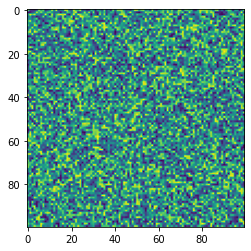

In [37]:
RandomField = np.random.rand( GridSize , GridSize )

plt.imshow( RandomField )
plt.show()

## Smooth the random field

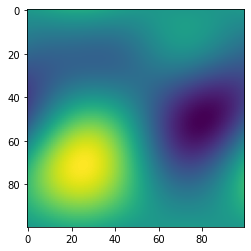

In [38]:
StreamFunction = sp.gaussian_filter( RandomField , sigma=SmoothenSigma , mode='wrap' )

plt.imshow( StreamFunction )
plt.show()

## Flow from stream function: $\psi$
### For any smooth random scalar field $\psi$, the velocity field is given by
### $ \vec{u} = \nabla \times \psi $
### such that, $\nabla . \vec{u} = 0$, i.e. incompressible.

## Calculation of velocity field

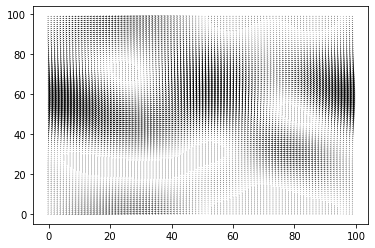

In [39]:
Vx =  np.gradient( StreamFunction , axis=0 )
Vy = -np.gradient( StreamFunction , axis=1 )

plt.quiver( Vx , Vy , units='width' )
plt.show()

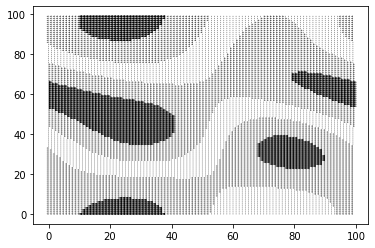

In [40]:
MagV = np.sqrt( Vx * Vx + Vy * Vy )
MaxMagV = np.max( MagV )

Vx = np.round( Vx * MaxShift / MaxMagV )
Vy = np.round( Vy * MaxShift / MaxMagV )
Vy = 0 * Vy

plt.quiver( Vx , Vy , units='width' )
plt.show()

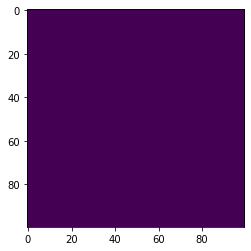

In [41]:
plt.imshow(Vy)

In [42]:
Frame1 = np.random.rand( GridSize , GridSize )
Frame2 = np.copy( Frame1 )

for XShift in range(-MaxShift , MaxShift):
    for YShift in range(-MaxShift , MaxShift):
        I = ((Vx<XShift) * (Vy==YShift))

        OverlayFrame = np.random.rand( GridSize , GridSize )

        Frame1 = Frame1 * (1-I) + OverlayFrame * I

        I = np.roll( I , XShift , axis=0 )
        I = np.roll( I , YShift , axis=1 )

        OverlayFrame = np.roll( OverlayFrame , YShift , axis=0 )
        OverlayFrame = np.roll( OverlayFrame , XShift , axis=1 )

        Frame2 = Frame2 * (1-I) + OverlayFrame * I

In [43]:
Frame1 = np.random.rand( GridSize , GridSize )
Frame2 = np.copy( Frame1 )

YShift = 0

for XShift in range(-MaxShift , MaxShift):
    I = ((Vx>XShift))

    OverlayFrame = np.random.rand( GridSize , GridSize )

    Frame1 = Frame1 * (1-I) + OverlayFrame * I

    I = np.roll( I , XShift , axis=0 )
    I = np.roll( I , YShift , axis=1 )

    OverlayFrame = np.roll( OverlayFrame , YShift , axis=0 )
    OverlayFrame = np.roll( OverlayFrame , XShift , axis=1 )

    Frame2 = Frame2 * (1-I) + OverlayFrame * I

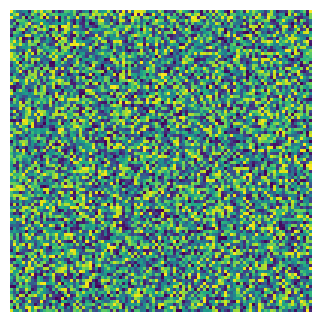

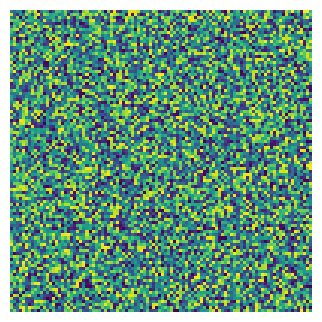

In [44]:
fig = plt.figure(figsize=(4,4), dpi=100)
plt.imshow( Frame1 )
plt.axis('off')
plt.savefig('Frame1.png',bbox_inches='tight',transparent=False,pad_inches = 0)

fig = plt.figure(figsize=(4,4), dpi=100)
plt.imshow( Frame2 )
plt.axis('off')
plt.savefig('Frame2.png',bbox_inches='tight',transparent=False,pad_inches = 0)

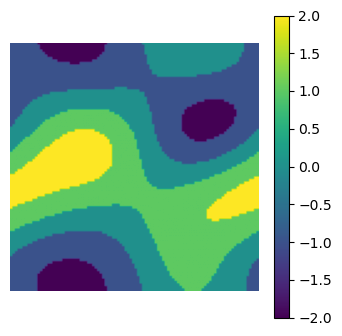

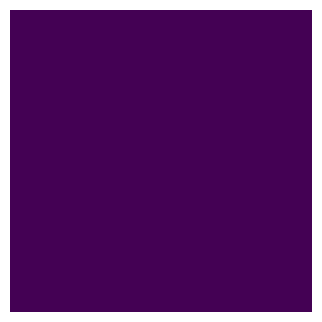

In [45]:
fig = plt.figure(figsize=(4,4), dpi=100)
plt.imshow( Vx )
plt.colorbar()
plt.axis('off')
plt.savefig('Vx.png',bbox_inches='tight',transparent=False,pad_inches = 0)

fig = plt.figure(figsize=(4,4), dpi=100)
plt.imshow( Vy )
plt.axis('off')
plt.savefig('Vy.png',bbox_inches='tight',transparent=False,pad_inches = 0)

In [46]:
DataSize = 10000
WindowSize = 5
LabelSize = 2*MaxShift + 1

Height, Width = Frame1.shape
HalfWindowSize = int( WindowSize/2 )

TrainImages = np.zeros([DataSize,WindowSize,WindowSize,2])
TrainLabels = np.zeros([DataSize,],dtype=np.uint8)

In [47]:
for i in range(DataSize):
    XShift = int( np.floor( np.random.rand(1) * Width ) )
    YShift = int( np.floor( np.random.rand(1) * Height ) )

    XXShift = int( np.floor( np.random.rand(1) * 2*MaxShift ) ) - MaxShift

    ShiftedFrame1 = np.roll( Frame1 , (YShift,XShift) , axis=(0,1) )
    ShiftedFrame2 = np.roll( Frame1 , (YShift,XShift+XXShift) , axis=(0,1) )

    TrainImages[i,:,:,0] = ShiftedFrame1[0:WindowSize,0:WindowSize]
    TrainImages[i,:,:,1] = ShiftedFrame2[0:WindowSize,0:WindowSize]

    TrainLabels[i,0] = XXShift + MaxShift

In [48]:
TestImages = np.zeros([DataSize,WindowSize,WindowSize,2])
TestLabels = np.zeros([DataSize,1],dtype=np.uint8)

In [49]:
for i in range(DataSize):
    XShift = int( np.floor( np.random.rand(1) * Width ) )
    YShift = int( np.floor( np.random.rand(1) * Height ) )

    XXShift = int( np.floor( np.random.rand(1) * 2*MaxShift ) ) - MaxShift

    ShiftedFrame1 = np.roll( Frame1 , (YShift,XShift) , axis=(0,1) )
    ShiftedFrame2 = np.roll( Frame1 , (YShift,XShift+XXShift) , axis=(0,1) )

    TestImages[i,:,:,0] = ShiftedFrame1[0:WindowSize,0:WindowSize]
    TestImages[i,:,:,1] = ShiftedFrame2[0:WindowSize,0:WindowSize]

    TestLabels[i,0] = XXShift + MaxShift

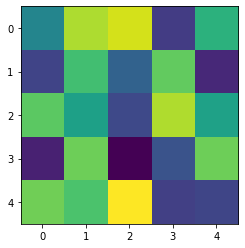

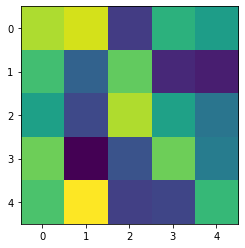

2


In [50]:
plt.imshow(TrainImages[10,:,:,0])
plt.show()

plt.imshow(TrainImages[10,:,:,1])
plt.show()

print(TrainLabels[10,0])

In [51]:
model = models.Sequential()

model.add( layers.Conv2D( filters=32 , kernel_size=3 , strides=(1, 1) , activation='relu' , input_shape=(WindowSize, WindowSize, 2)) )

# model.add( layers.MaxPooling2D((2, 2)) )

# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense( 2*MaxShift+1 ))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 3, 3, 32)          608       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 1, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 7)                 455       
                                                                 
Total params: 3,175
Trainable params: 3,175
Non-trainable params: 0
____________________________________________________

In [52]:
model.compile( optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(TrainImages, TrainLabels, epochs=20, 
                    validation_data=(TestImages, TestLabels))

Epoch 1/20
313/313 [==============================] - 1s 3ms/step - loss: 1.6491 - accuracy: 0.4175 - val_loss: 1.3247 - val_accuracy: 0.6490
Epoch 2/20
313/313 [==============================] - 1s 3ms/step - loss: 0.9186 - accuracy: 0.7448 - val_loss: 0.5685 - val_accuracy: 0.8309
Epoch 3/20
313/313 [==============================] - 1s 3ms/step - loss: 0.4263 - accuracy: 0.8615 - val_loss: 0.3298 - val_accuracy: 0.8860
Epoch 4/20
313/313 [==============================] - 1s 3ms/step - loss: 0.2702 - accuracy: 0.9095 - val_loss: 0.2194 - val_accuracy: 0.9321
Epoch 5/20
313/313 [==============================] - 1s 3ms/step - loss: 0.1852 - accuracy: 0.9454 - val_loss: 0.1511 - val_accuracy: 0.9609
Epoch 6/20
313/313 [==============================] - 1s 3ms/step - loss: 0.1269 - accuracy: 0.9693 - val_loss: 0.1077 - val_accuracy: 0.9738
Epoch 7/20
313/313 [==============================] - 1s 3ms/step - loss: 0.0927 - accuracy: 0.9798 - val_loss: 0.0820 - val_accuracy: 0.9808
Epoch 

In [53]:
ii = 1010
np.argmax( model.predict( TrainImages[ii:(ii+1)] ) )


1/1 [==============================] - 0s 82ms/step


5

In [54]:
TrainLabels[ii]

array([5], dtype=uint8)

In [55]:
ii = 570
print( np.argmax(model.predict( TrainImages[ii:(ii+1)] )) )
print( TrainLabels[ii:(ii+1)] )

1/1 [==============================] - 0s 18ms/step
0
[[0]]


In [56]:
PredictedLabel=np.argmax(model.predict( TestImages ),axis=1)

313/313 [==============================] - 0s 939us/step


In [57]:
Input = np.zeros([Width*Height,WindowSize,WindowSize,2])

In [58]:
k = 0

for i in range(Height):
    for j in range(Width):

        ShiftedFrame1 = np.roll( Frame1 , (i,j) , axis=(0,1) )
        ShiftedFrame2 = np.roll( Frame2 , (i,j) , axis=(0,1) )

        Input[k,:,:,0] = ShiftedFrame1[0:WindowSize,0:WindowSize]
        Input[k,:,:,1] = ShiftedFrame2[0:WindowSize,0:WindowSize]

        k = k+1

In [59]:
model.predict( Input )

313/313 [==============================] - 0s 916us/step


array([[  5.459743 ,  14.257113 ,  -4.551702 , ..., -17.173124 ,
         -1.2470316, -14.1414385],
       [  2.190775 ,  10.038022 ,  -8.310821 , ..., -14.042434 ,
          2.9033427, -12.728955 ],
       [  3.6175258,  12.296467 ,  -6.4815154, ...,  -4.2140546,
         -9.880711 , -14.770454 ],
       ...,
       [  6.6390853,  14.899119 , -13.518512 , ..., -19.205488 ,
         -2.6530771, -14.889734 ],
       [  6.679162 ,  16.699697 , -18.081854 , ...,  -9.505413 ,
         -9.26042  , -15.510318 ],
       [  5.4393773,  14.266873 , -13.849117 , ...,  -7.6522098,
         -9.519436 , -13.750398 ]], dtype=float32)

In [60]:
PredictedLabel = np.argmax( model.predict( Input ) , axis=1 )

313/313 [==============================] - 0s 916us/step


In [61]:
PredictedVx = np.reshape( PredictedLabel , [Width,Height] )

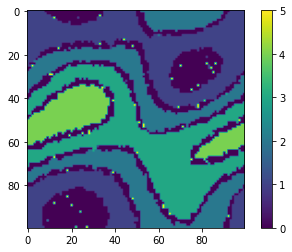

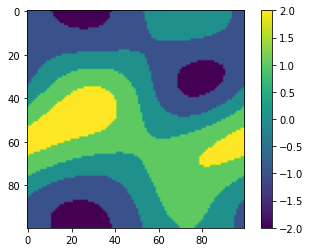

In [62]:
plt.imshow( np.rot90(np.rot90(PredictedVx)) )
plt.colorbar()
plt.show()

plt.imshow( Vx )
plt.colorbar()
plt.show()

In [63]:
np.min(PredictedVx)

0